# Hebridean Whale and Dolphin Trust #
## Data Analysis ##

---
This notebook analyses the wrangled data created in the notebook

HWDT Data Wrangle.ipynb

--- 

Data provided by the following providers:<br><br>

<ul><li>Records provided by Hebridean Whale and Dolphin Trust, accessed through NBN Atlas website. (). For more information: email info@hwdt.org, or https://registry.nbnatlas.org/public/show/dp81</li><li>Hebridean Whale and Dolphin Trust (2022). Visual sightings data set 2003-2021. Occurrence dataset on the NBN Atlas (Creative Commons, with Attribution, Non-commercial v4.0 (CC-BY-NC) CC-BY-NC). For more information: email biodiversityofficer@hwdt.org, or https://registry.nbnatlas.org/public/show/dr537</li></ul>

---

## Imports

In [ ]:
% % capture
!pip install OSGridConverter


In [40]:
import pandas as pd
from datetime import datetime, date, time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from bokeh.io import output_notebook
output_notebook()

import plotly.express as px

import seaborn as sns

import folium

from OSGridConverter import grid2latlong
from OSGridConverter import latlong2grid

Loading BokehJS ...

## Parameter setup

Subject for analysis

In [45]:
name = "Basking Shark"

# The following subjects are available in the dataset
# 'Atlantic White-sided Dolphin', 'Basking Shark', 'Bottle-nosed Dolphin', 'Common Dolphin', 'Common Porpoise', 'Eurasian Otter', 'Fin Whale', 'Grey Seal', 'Harbour Seal', 'Humpback Whale', 'Killer Whale', 'Leathery Turtle', 'Long-finned Pilot Whale', 'Minke Whale', "Risso's Dolphin", 'Striped Dolphin', 'Sun-fish', 'White-beaked Dolphin'



Constants

In [104]:
import_file = 'Data/export-2022.csv'

# Which OS bins to use for the high/low level maps
ll_OSGbin = 'OSG 1km' 
hl_OSGbin = 'OSG 10km'
#map_tiles = 'Stamen Terrain'
map_tiles = 'CartoDB Dark_Matter'
colours = ['#eff3ff','#bdd7e7','#6baed6','#2171b5']
years = []
for f in range(2003,2022):
    years.append(str(f))


## Import Data

In [4]:
dw = pd.read_csv(import_file, parse_dates=["Date"])

dw.head()

,Occurrence ID,Scientific name,Common name,Date,Date day,Date month,Date year,OSGR,Latitude,Longitude,Coordinate uncertainty (m),Individual count,Life stage,Country,OSG 10m,OSG 100m,OSG 1km,OSG 10km,OSG 100km
0,13277,Orcinus orca,Killer Whale,2019-12-20,20,12,2019,NM3685461143,56.667782,-6.296667,1000.0,1.0,Adult,Scotland,NM36856114,NM368611,NM3661,NM36,NM
1,13273,Halichoerus grypus,Grey Seal,2019-11-26,26,11,2019,NM3943766893,56.720737,-6.260450,220.0,1.0,Adult,Scotland,NM39436689,NM394668,NM3966,NM36,NM
2,13271,Phocoena phocoena,Common Porpoise,2019-11-26,26,11,2019,NM5948576238,56.815250,-5.942466,400.0,1.0,Adult,Scotland,NM59487623,NM594762,NM5976,NM57,NM
3,14169,Delphinus delphis,Common Dolphin,2021-11-05,5,11,2021,NM2450970256,56.742290,-6.507234,150.0,1.0,Adult,Scotland,NM24507025,NM245702,NM2470,NM27,NM
4,13261,Phocoena phocoena,Common Porpoise,2019-11-25,25,11,2019,NM5149975640,56.805698,-6.072366,200.0,1.0,Adult,Scotland,NM51497564,NM514756,NM5175,NM57,NM


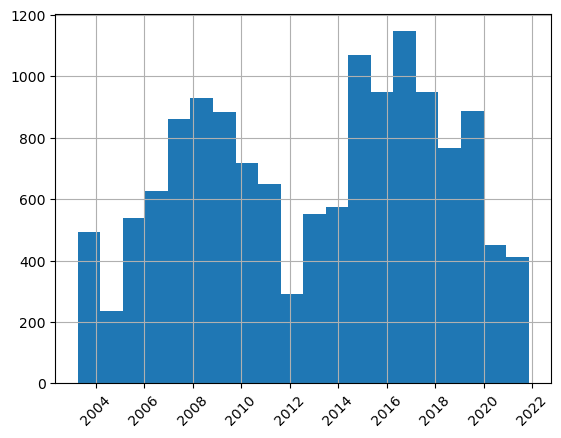

In [5]:
dw['Date'].hist(bins=20,xrot=45)
plt.show()

In [6]:
fig = px.histogram(dw, x='Date', nbins=20,text_auto=False, title="Observations over time", color='Common name')
fig.update_layout(yaxis_title='Observations', xaxis_title='')
fig.show()

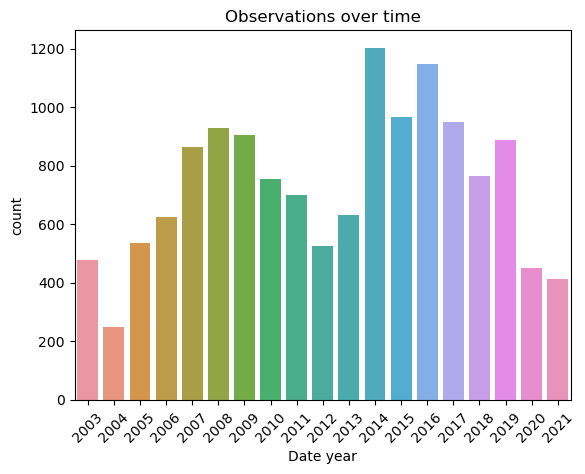

In [7]:
g = sns.countplot(data=dw,x='Date year')
g.set_xticklabels(labels=years,rotation=45)
plt.title("Observations over time")
plt.show()

In [8]:
dw_totals = dw.groupby(['Common name'])['Individual count'].agg(['sum','count'])
dw_totals.columns = ['Individual count','Observations']
dw_totals = dw_totals.reset_index()
dw_totals = dw_totals.sort_values(by='Individual count')

fig = px.bar(dw_totals,y='Common name', color='Individual count', x='Observations',text_auto=True)
fig.update_layout(title='Total Spotted Individuals')
fig.show()

In [9]:
dw_totals

,Common name,Individual count,Observations
15,Striped Dolphin,1.0,1
12,Long-finned Pilot Whale,2.0,2
6,Fin Whale,2.0,2
11,Leathery Turtle,2.0,2
9,Humpback Whale,7.0,6
5,Eurasian Otter,14.0,14
16,Sun-fish,36.0,34
10,Killer Whale,67.0,21
0,Atlantic White-sided Dolphin,108.0,4
2,Bottle-nosed Dolphin,260.0,65


In [10]:
tmp = dw.groupby(['Common name',"Date year"])[['Individual count']].sum()
tmp = tmp.reset_index()
dw_yr_pv = tmp.pivot_table(index="Date year", columns='Common name', values='Individual count')
dw_yr_pv = dw_yr_pv.fillna(0)

dw_yr_pv = dw_yr_pv.reset_index()

In [11]:
dw_yr_pv

Common name,Date year,Atlantic White-sided Dolphin,Basking Shark,Bottle-nosed Dolphin,Common Dolphin,Common Porpoise,Eurasian Otter,Fin Whale,Grey Seal,Harbour Seal,Humpback Whale,Killer Whale,Leathery Turtle,Long-finned Pilot Whale,Minke Whale,Risso's Dolphin,Striped Dolphin,Sun-fish,White-beaked Dolphin
0,2003,0.0,83.0,29.0,50.0,415.0,0.0,0.0,78.0,40.0,0.0,1.0,0.0,0.0,87.0,42.0,1.0,2.0,7.0
1,2004,0.0,43.0,8.0,0.0,208.0,0.0,0.0,34.0,16.0,0.0,6.0,0.0,1.0,52.0,1.0,0.0,1.0,0.0
2,2005,0.0,111.0,5.0,73.0,609.0,0.0,0.0,99.0,76.0,0.0,15.0,0.0,0.0,42.0,10.0,0.0,8.0,0.0
3,2006,0.0,241.0,27.0,134.0,452.0,0.0,0.0,133.0,33.0,1.0,0.0,0.0,0.0,45.0,3.0,0.0,1.0,18.0
4,2007,0.0,130.0,29.0,392.0,834.0,0.0,0.0,169.0,50.0,1.0,9.0,0.0,0.0,52.0,25.0,0.0,5.0,95.0
5,2008,33.0,155.0,22.0,228.0,784.0,0.0,1.0,178.0,126.0,0.0,12.0,0.0,0.0,50.0,14.0,0.0,3.0,68.0
6,2009,75.0,199.0,14.0,265.0,662.0,0.0,0.0,238.0,145.0,1.0,4.0,0.0,0.0,65.0,20.0,0.0,2.0,107.0
7,2010,0.0,360.0,18.0,381.0,489.0,0.0,0.0,108.0,106.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,3.0,34.0
8,2011,0.0,52.0,2.0,780.0,594.0,0.0,1.0,199.0,65.0,0.0,0.0,1.0,0.0,73.0,15.0,0.0,2.0,149.0
9,2012,0.0,188.0,22.0,315.0,273.0,0.0,0.0,130.0,98.0,0.0,5.0,0.0,0.0,50.0,6.0,0.0,2.0,35.0


In [47]:
fig = px.line(
    dw_yr_pv,
     x='Date year' , 
    y=name,
    title= name + "s Spotted Over Time"
    )
fig.update_layout(
    yaxis_title='Count of ' + name + 's', 
    xaxis_title='', 
    showlegend=False
    )
fig.show()

In [13]:

fig = px.line(
    dw_yr_pv, 
    x='Date year' , 
    y=["Common Dolphin","Common Porpoise"], 
    title="Dolphins vs Porpoises Over Time",
    )
    
fig.update_layout(yaxis_title='Number Spotted', xaxis_title='', showlegend=True, legend_title='')
#fig.update_traces(line_dash="Common Dolphin")
fig.show()

# Mapping #
---


In [14]:

# Create high level table for mapping
dw_hl_osg = dw.groupby([hl_OSGbin,'Common name'])['Individual count'].sum()
dw_hl_osg = dw_hl_osg.reset_index()
dw_hl_osg = dw_hl_osg.pivot_table(index=hl_OSGbin, values='Individual count', columns='Common name')
dw_hl_osg = dw_hl_osg.fillna(0)
dw_hl_osg['Total'] = dw_hl_osg.agg('sum', axis=1)
dw_hl_osg = dw_hl_osg.sort_values(by='Total')
#dw_hl_osg

In [15]:

# Create low level table for mapping
dw_ll_osg = dw.groupby([ll_OSGbin,'Common name'])['Individual count'].sum()
dw_ll_osg = dw_ll_osg.reset_index()
dw_ll_osg = dw_ll_osg.pivot_table(index=ll_OSGbin, values='Individual count', columns='Common name')
dw_ll_osg = dw_ll_osg.fillna(0)
dw_ll_osg['Total'] = dw_ll_osg.agg('sum', axis=1)
dw_ll_osg = dw_ll_osg.sort_values(by='Total')
#dw_ll_osg

In [48]:
# Select data for high level map

dw_hl_osg_ind = dw_hl_osg.loc[dw_hl_osg[name] > 0][[name]]
dw_hl_osg_ind.columns = ["Total"]

max_osgrid = dw_hl_osg_ind.loc[dw_hl_osg_ind['Total'].max()==dw_hl_osg_ind['Total']].reset_index().iloc[0,0]
hl_focus_latlong = grid2latlong(max_osgrid) # used to centre map on location with max individual count


In [49]:
# Select data for low level map

dw_ll_osg_ind = dw_ll_osg.loc[dw_ll_osg[name] > 0][[name]]
dw_ll_osg_ind.columns = ["Total"]

max_osgrid = dw_ll_osg_ind.loc[dw_ll_osg_ind['Total'].max()==dw_ll_osg_ind['Total']].reset_index().iloc[0,0]
ll_focus_latlong = grid2latlong(max_osgrid) # used to centre map on location with max individual count


In [103]:
llq = dw_ll_osg_ind['Total'].quantile(np.arange(0.50, 1, 0.20))
hlq = dw_hl_osg_ind['Total'].quantile(np.arange(0.50, 1, 0.20))

## High Level Map ##

Build the map

In [108]:
# High Level Map

m = folium.Map(
    location=[hl_focus_latlong.latitude, hl_focus_latlong.longitude],
    tiles=map_tiles,
    zoom_start=7,
    max_zoom=10,
    min_zoom=6,
    control_scale=True
    )
    
spot_latlog = []
spot_colour = colours[3]
spot_stroke = False
spot_fill_opacity = 0.1
spot_radius = 5000

for idx in dw_hl_osg_ind.index:
    row = dw_hl_osg_ind.loc[idx]
    os2gps = grid2latlong(idx)
    spot_latlog.append([os2gps.latitude,os2gps.longitude])
    popup_text = name + ' count ' + str(int(row['Total']))

    if row['Total'] <= hlq.iloc[0]:
        spot_colour = colours[3]
        spot_fill_opacity = 0.4
    elif row['Total'] <= hlq.iloc[1]:
        spot_colour = colours[2]
        spot_stroke = False
        spot_fill_opacity = 0.4
    elif row['Total'] <= hlq.iloc[2]:
        spot_colour = colours[1]
        spot_stroke = False
        spot_fill_opacity = 0.4
    else:
        spot_colour = colours[0]
        spot_stroke = True
        spot_fill_opacity = 0.6

    folium.Circle(
        radius=spot_radius,
        location=[os2gps.latitude,os2gps.longitude],
        color=spot_colour,
        stroke=spot_stroke,
        weight=2,
        opacity=.6,
        fill=True,
        fill_opacity=spot_fill_opacity,
        popup = popup_text
    ).add_to(m)


df_latlong = pd.DataFrame(spot_latlog, columns=['Lat', 'Long'])

sw = df_latlong[['Lat', 'Long']].min().values.tolist()
ne = df_latlong[['Lat', 'Long']].max().values.tolist()
m.fit_bounds([sw, ne])

Display the map

In [109]:
m.save(name+" high level map.html")
m

## Low Level Map ##


Build the map

In [120]:
# Low level map

map_tiles = 'CartoDB Dark_Matter'

m = folium.Map(
    location=[ll_focus_latlong.latitude, ll_focus_latlong.longitude],
    tiles=map_tiles,
    zoom_start=9,
    max_zoom=13,
    min_zoom=5,
    control_scale=True
    )
    

spot_latlog = []
spot_colour = colours[3]
spot_stroke = False
spot_fill_opacity = 0.1
spot_radius = 500

for idx in dw_ll_osg_ind.index:
    row = dw_ll_osg_ind.loc[idx]
    os2gps = grid2latlong(idx)
    spot_latlog.append([os2gps.latitude,os2gps.longitude])
    popup_text = name + ' count ' + str(int(row['Total']))

    if row['Total'] <= llq.iloc[0]:
        spot_colour = colours[3]
        spot_fill_opacity = 0.4
    elif row['Total'] <= llq.iloc[1]:
        spot_colour = colours[2]
        spot_stroke = False
        spot_fill_opacity = 0.4
    elif row['Total'] <= llq.iloc[2]:
        spot_colour = colours[1]
        spot_stroke = False
        spot_fill_opacity = 0.4
    else:
        spot_colour = colours[0]
        spot_stroke = True
        spot_fill_opacity = 0.6

    folium.Circle(
        radius=spot_radius,
        location=[os2gps.latitude,os2gps.longitude],
        color=spot_colour,
        stroke=spot_stroke,
        weight=2,
        opacity=.6,
        fill=True,
        fill_opacity=spot_fill_opacity,
        popup = popup_text
    ).add_to(m)


df_latlong = pd.DataFrame(spot_latlog, columns=['Lat', 'Long'])

sw = df_latlong[['Lat', 'Long']].min().values.tolist()
ne = df_latlong[['Lat', 'Long']].max().values.tolist()
#m.fit_bounds([sw, ne])


Display the map

In [121]:
m.save(name+" low level map.html")
m